# Content-based Recommendation System: IMDB Movies

**Project:** a recommendation system to find similar movies based on data related to movie content only and not on movie popularity or critical reception

We will build a *resemblance space* based on categorical variables only. My goal is to focus on the choice of the right distance metric in this particular case and to address the issues related to distances computation on a sparse dataset. I will show the importance of data standardization and data transformation methods in distance computations.

----------------------
*(For a more complete exploration of data standardization, transformation and distance assessment, please see the companion notebook in this repository: [Distance_Assessment](2.Annex_Distance_assessment.ipynb))*

----------------------------------

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
donnees = pd.read_csv('donnees2.csv',sep=';', 
                       encoding='utf-8',index_col=0)
print('dataset shape: ',donnees.shape, '\n')
print('Variables: \n', donnees.columns)

dataset shape:  (4645, 24) 

Variables: 
 Index(['index', 'color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'genres', 'actor_1_name', 'movie_title',
       'num_voted_users', 'cast_total_facebook_likes', 'actor_3_name',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'country',
       'content_rating', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'movie_facebook_likes'],
      dtype='object')


The dataset comes from IMDB. It was already cleaned for this project and available for demonstration in this repository.
Part of the variables describes  the interest for the movie among users of the site (e.g. number of users who voted on the site) or the critical reception of the movie (e.g. IMDB score).

Here I want to focus only on the movie content and I select only variables related to
- Names of directors and main actors
- broad genre (eg Adventure, Drama etc) and official content rating (eg PG-13)
- plot keywords


In [3]:
donnees[['director_name', 'content_rating', 'genres', 'plot_keywords', 
         'actor_1_name', 'actor_2_name', 'actor_3_name']].head()

,director_name,content_rating,genres,plot_keywords,actor_1_name,actor_2_name,actor_3_name
0,James Cameron,PG-13,Action|Adventure|Fantasy|Sci-Fi,avatar|future|marine|native|paraplegic,CCH Pounder,Joel David Moore,Wes Studi
1,Gore Verbinski,PG-13,Action|Adventure|Fantasy,goddess|marriage ceremony|marriage proposal|pi...,Johnny Depp,Orlando Bloom,Jack Davenport
2,Sam Mendes,PG-13,Action|Adventure|Thriller,bomb|espionage|sequel|spy|terrorist,Christoph Waltz,Rory Kinnear,Stephanie Sigman
3,Christopher Nolan,PG-13,Action|Thriller,deception|imprisonment|lawlessness|police offi...,Tom Hardy,Christian Bale,Joseph Gordon-Levitt
4,Andrew Stanton,PG-13,Action|Adventure|Sci-Fi,alien|american civil war|male nipple|mars|prin...,Daryl Sabara,Samantha Morton,Polly Walker


#### Can we assess similarities among movies based on the above informations only?

The retained variables are categorical variables. To compute distances among movies based on these variables we'll encode the dataset to display the presence or absence of each feature (variable modality). We expect that the encoded dataset will have the following characterictics:
- Binary data: values 0 (absence) or 1 (presence)
- Sparse: Most part of the data will be zeros

----------------------------------------------------


# 1. Categorical variables processing

In [4]:
from utils import extract_cat

function *extract_cat()* relies on the CountVectorizer() function from sklearn to extract different keywords and discard separators.

I chose the regular expression to preserve keywords as they were entered: they can be composed of one word or an expression with a few words and can potentially contain '.' or '-'

The function returns a Dataframe with features in columns and their count per movies in lines

In [5]:
df_genres = extract_cat(donnees['genres'],token_pattern='[\w-]+',
                       verbose=True)

length vocabulary:  24
vocabulary: 
 {'action': 0, 'adventure': 1, 'fantasy': 9, 'sci-fi': 18, 'thriller': 21, 'romance': 17, 'animation': 2, 'comedy': 4, 'family': 8, 'musical': 14, 'mystery': 15, 'western': 23, 'drama': 7, 'history': 11, 'sport': 20, 'crime': 5, 'horror': 12, 'war': 22, 'biography': 3, 'music': 13, 'documentary': 6, 'news': 16, 'short': 19, 'film-noir': 10}


In [6]:
df_keywords = extract_cat(donnees['plot_keywords'],
                          token_pattern='[\w.\-\s]+', verbose=True)

length vocabulary:  7982
vocabulary: 
 {'avatar': 511, 'future': 2827, 'marine': 4240, 'native': 4686, 'paraplegic': 5074, 'goddess': 2986, 'marriage ceremony': 4253, 'marriage proposal': 4256, 'pirate': 5227, 'singapore': 6460, 'bomb': 861, 'espionage': 2291, 'sequel': 6280, 'spy': 6718, 'terrorist': 7127, 'deception': 1861, 'imprisonment': 3516, 'lawlessness': 3909, 'police officer': 5316, 'terrorist plot': 7131, 'alien': 217, 'american civil war': 264, 'male nipple': 4189, 'mars': 4258, 'princess': 5453, 'sandman': 6124, 'spider man': 6698, 'symbiote': 6997, 'venom': 7577, 'villain': 7611, '17th century': 23, 'based on fairy tale': 624, 'disney': 1978, 'flower': 2696, 'tower': 7297, 'artificial intelligence': 432, 'based on comic book': 619, 'captain america': 1122, 'marvel cinematic universe': 4272, 'superhero': 6928, 'blood': 817, 'book': 877, 'love': 4094, 'potion': 5397, 'professor': 5484, 'batman': 665, 'sequel to a reboot': 6281, 'superman': 6932, 'crystal': 1723, 'epic': 2272

In [7]:
#to avoid duplicate column names between different df
df_keywords.columns = 'KW_' + df_keywords.columns
df_keywords.head()

,KW_ daughter,KW_ roll,KW_ school,KW_ soccer,KW_10 year old,KW_1000000 b.c.,KW_1190s,KW_12 step program,KW_12 year old,KW_12 year time span,...,KW_zodiac,KW_zodiac killer,KW_zoloft,KW_zombie,KW_zombie apocalypse,KW_zombie spoof,KW_zoo,KW_zookeeper,KW_zoologist,KW_zorro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The 3 variables 'actor_1_name', 'actor_2_name', 'actor_3_name' are first regrouped in one single variable, then encoded to obtain a Dataframe 'df_actors' with the count of the different actors in a movie (disregarding if they were listed as the first, second or third actor on the cast list)

In [8]:
def str_merge(dat):
    string = donnees['actor_1_name']+";"+donnees['actor_2_name']+";"+\
    donnees['actor_3_name']
    return string
donnees['actors'] = str_merge(donnees[['actor_1_name','actor_2_name',
                             'actor_3_name']])
df_actors = extract_cat(donnees['actors'],
                          token_pattern='[\w.\-\s]+', verbose=True)

length vocabulary:  5887
vocabulary: 
 {'cch pounder': 858, 'joel david moore': 2702, 'wes studi': 5742, 'johnny depp': 2798, 'orlando bloom': 4255, 'jack davenport': 2266, 'christoph waltz': 1001, 'rory kinnear': 4816, 'stephanie sigman': 5208, 'tom hardy': 5517, 'christian bale': 980, 'joseph gordon-levitt': 2861, 'daryl sabara': 1270, 'samantha morton': 4926, 'polly walker': 4479, 'j.k. simmons': 2260, 'james franco': 2348, 'kirsten dunst': 3195, 'brad garrett': 643, 'donna murphy': 1495, 'm.c. gainey': 3519, 'chris hemsworth': 958, 'robert downey jr.': 4726, 'scarlett johansson': 4988, 'alan rickman': 120, 'daniel radcliffe': 1216, 'rupert grint': 4855, 'henry cavill': 2140, 'lauren cohan': 3280, 'alan d. purwin': 112, 'kevin spacey': 3155, 'marlon brando': 3664, 'frank langella': 1834, 'giancarlo giannini': 1971, 'mathieu amalric': 3715, 'ruth wilson': 4865, 'tom wilkinson': 5532, 'christopher meloni': 1017, 'harry lennix': 2103, 'peter dinklage': 4407, 'pierfrancesco favino': 446

Finally, we build a single dataset 'df_cat1'. The function *get_dummies* is used to encode the variables 'director_name' and 'content_rating'

In [9]:
df_cat1 = pd.concat([donnees[['director_name', 'content_rating']],
                     df_genres, df_actors, df_keywords],axis=1)
df_cat1 = pd.get_dummies(df_cat1)
print('df_cat1: ', df_cat1.shape)
display(df_cat1.head())

df_cat1:  (4645, 16160)


,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,director_name_Álex de la Iglesia,director_name_Émile Gaudreault,director_name_Éric Tessier,director_name_Étienne Faure,content_rating_G,content_rating_NC-17,content_rating_Not Rated,content_rating_PG,content_rating_PG-13,content_rating_R
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Comments on variables

As expected the final dataset contains a large number of columns

The two variables 'content_rating' and 'genres' have few modalities, most modalities being well represented in the dataset

The other variables on the other hand ('director_name', 'actors', 'plot_keywords') are full of modalities poorly represented in the dataset, that's what is making our binary dataset so big... and so sparse!

In [10]:
donnees['content_rating'].value_counts()

R            2038
PG-13        1394
PG            682
Not Rated     402
G             110
NC-17          19
Name: content_rating, dtype: int64

In [11]:
df_genres.sum(axis=0)

action         1074
adventure       863
animation       227
biography       285
comedy         1772
crime           820
documentary      94
drama          2384
family          503
fantasy         560
film-noir         6
history         192
horror          518
music           200
musical         126
mystery         449
news              2
romance        1047
sci-fi          571
short             4
sport           176
thriller       1306
war             201
western          89
dtype: int64

In [12]:
tmp = donnees['director_name'].value_counts()
print('Number of directors: ',len(tmp))
print('highest frequency: ',max(tmp), ' ({})'.format(tmp.index[0]))
print('Number of directors featured only once: ',len(tmp[tmp==1]))

Number of directors:  2261
highest frequency:  26  (Steven Spielberg)
Number of directors featured only once:  1403


In [13]:
tmp = df_actors.sum(axis=0)
print('Number of actors: ',len(tmp))
print('highest frequency: ',max(tmp), ' ({})'.format(tmp.iloc[np.where(tmp==max(tmp))].index[0]))
print('Number of actors featured only once: ',len(tmp[tmp==1]))

Number of actors:  5887
highest frequency:  53  (robert de niro)
Number of actors featured only once:  3671


In [14]:
tmp = df_keywords.sum(axis=0)
print('Number of keywordss: ',len(tmp))
print('highest frequency: ',max(tmp), ' ({})'.format(tmp.iloc[np.where(tmp==max(tmp))].index[0]))
print('Number of keywords featured only once: ',len(tmp[tmp==1]))

Number of keywordss:  7982
highest frequency:  189  (KW_love)
Number of keywords featured only once:  4995


# Distance as a measure of difference in a sparse binary dataset

After processing, we have a dataset of categorical variables (binary encoded) related to the content of the movies: names of realisator and actors, genre(s) and content rating, plus a few keywords for the plotline.

Our dataset describes a content-based resemblance space where we would like to assess the similarities / differences among movies by their relative distances in the space. However we should consider a few more steps first: data standardization and transformation

*(For a more complete exploration of data standardization, transformation and distance assessment, please see the companion notebook in this repository: [Distance_Assessment](2.Annex_Distance_assessment.ipynb))*

# 2.Distances and data standardization

Before diving into our dataset, let's assess the behavior of the Euclidean distance on this kind of binary dataset

In [15]:
from sklearn.neighbors import NearestNeighbors

In [16]:
def nn_results(df, n_neighbors=2, metric='euclidean', target=None):
    '''Convenient function:
    Fit a NearestNeighbors model
    and shows the resulting neigbors with their distances to target'''
    from sklearn.neighbors import NearestNeighbors
    if target is None:
        target = 0
    NN1 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto',
                           metric=metric)
    NN1.fit(df)
    distances, neighb = NN1.kneighbors([np.array(df.iloc[target])],
                                       return_distance=True)
    print('Nearest neighbors: \n', neighb)
    print('Distances to target {}: \n'.format(target), distances)
    return neighb, distances

In [17]:
df_test = pd.DataFrame({'Blue':[1,0,1,1], 'Red':[1,0,0,0],'Yellow':[0,1,1,1], 'Green': [0,0,0,1]})
display(df_test)

,Blue,Green,Red,Yellow
0,1,0,1,0
1,0,0,0,1
2,1,0,0,1
3,1,1,0,1


In [18]:
nn_results(df_test,n_neighbors=4);

Nearest neighbors: 
 [[0 2 1 3]]
Distances to target 0: 
 [[0.         1.41421356 1.73205081 1.73205081]]


Here we'd like to compare 4 objects based on their colors. What happens if we use euclidean distances to look for similarities among our objects?

The target object is blue and red

The object 1 that shares no color with the target is considered as similar to the target than the object 3 that shares the color blue with the target but is also green... 

In our case, we'd rather say than the blue-green object is more similar to the blue-red object than the yellow object!

 With euclidean distances both double-presence (like blue for objects 0 and 3) and double-absence (like green for objects 0 and 1) count for a similarity.
Only presence vs absence cases are counted as true differences and the euclidean distane is the square root of the number of true differences.


In [19]:
from utils import df_normalization
df_test_normed = df_normalization(df_test)
nn_results(df_test_normed,n_neighbors=4, metric='euclidean');

Nearest neighbors: 
 [[0 2 3 1]]
Distances to target 0: 
 [[0.         1.         1.08788943 1.41421356]]


In [20]:
df_test_normed

,Blue,Green,Red,Yellow
0,0.707107,0.00000,0.707107,0.000000
1,0.000000,0.00000,0.000000,1.000000
2,0.707107,0.00000,0.000000,0.707107
3,0.577350,0.57735,0.000000,0.577350


Normalizing the data (makes the sum of squares by lines equal to 1) before calculating Euclidean distances is a way to obtain a result similar to Jaccard's distance: The double-absences aren't considered in the distance computation.

Now, the object 1 that shares no color with the target is consistently credited with the greatest distance to the target.

### Let's see how it applies to our movie dataset

We will look after the nearest neighbors of the movie *Pulp Fiction* (number 3200 in the index).
![PulpFiction_pic](pulp_fiction.png)

We fit two different NearestNeighbors() models: euclidean distances on data without (baseline) and with standardization.

In [21]:
## Baseline model: raw data
NN1 = NearestNeighbors(n_neighbors=26, algorithm='auto', metric='euclidean')
NN1.fit(df_cat1)

##model with data standardization only
NN2 = NearestNeighbors(n_neighbors=26, algorithm='auto', metric='euclidean')
NN2.fit(df_normalization(df_cat1))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                 radius=1.0)

Let's define a function that we will use a few times to compare different methods

In [22]:
def plot_comparison(nn1, dd1, nn2, dd2, lab1='NN1', lab2='NN2', n_movies = 15):
    '''Convenient plotting function
    for comparison of 2 lists of movies
    from two Nearest Neighbors models'''
    
    fig = plt.figure(figsize=(15,n_movies*0.6))
    

    plt.subplot2grid((2, 6), (0, 0),colspan=2)
    plt.barh(range(n_movies),dd1.flatten()[:n_movies] ,color='green')
    plt.xscale('log')
    plt.xlabel('Distances (log scale)')
    plt.ylabel('Ranks')
    plt.title('NN Model {}'.format(lab1))
    
    plt.subplot2grid((2, 6), (0, 2))
    max_d = 0.1#(round(max(dd1.flatten()))+0.2)
    [plt.text(max_d,y,donnees.iloc[nn1.flatten()[y]]['movie_title']) for y in range(n_movies) ]
    plt.axis([0,100,-1,n_movies])
    plt.title('Movies') # just to adapt fig height compared to neighbors
    plt.axis('off')
    
    plt.subplot2grid((2, 6), (0, 3),colspan=2)
    plt.barh(range(n_movies),dd2.flatten()[:n_movies] ,color='orange')
    plt.xscale('log')
    plt.xlabel('Distances (log scale)')
    plt.ylabel('Ranks')
    plt.title('NN Model {}'.format(lab2))
    plt.suptitle('Distances among movies')
    
    plt.subplot2grid((2, 6), (0, 5))
    max_d = 0.1#(round(max(dd2.flatten()))+0.2)
    [plt.text(max_d,y,donnees.iloc[nn2.flatten()[y]]['movie_title']) for y in range(n_movies) ]
    plt.axis([0,100,-1,n_movies])
    plt.title('Movies') # just to adapt fig height compared to neighbors
    plt.axis('off')
    
    l1only = donnees.iloc[ [i for i in nn1.flatten() if i not in nn2.flatten() ]]['movie_title']
    l2only = donnees.iloc[ [i for i in nn2.flatten() if i not in nn1.flatten() ]]['movie_title']
    l12 = donnees.iloc[ [i for i in nn1.flatten() if i  in nn2.flatten() ]]['movie_title']
    ht = max(len(l1only),len(l2only),len(l12))+1
    
    plt.subplot2grid((2, 6), (1, 1),colspan=4)
    plt.bar([1,6,11], [len(l1only),len(l12), len(l2only)], width=4,color=['green','lightblue','orange'])
    [plt.text(0,y,l1only.iloc[y,], horizontalalignment='left') for y in range(len(l1only)) ]
    [plt.text(5,y,l12.iloc[y,], horizontalalignment='left') for y in range(len(l12)) ]
    [plt.text(10,y,l2only.iloc[y,], horizontalalignment='left') for y in range(len(l2only)) ]
    plt.text(0,ht,'{} only'.format(lab1))
    plt.text(5,ht,'{} & {}'.format(lab1, lab2))
    plt.text(10,ht,'{} only'.format(lab2))

    plt.show()

In [23]:
donnees[['director_name', 'content_rating', 'genres', 'plot_keywords', 
         'actor_1_name', 'actor_2_name', 'actor_3_name']].iloc[3200]

director_name                                     Quentin Tarantino
content_rating                                                    R
genres                                                  Crime|Drama
plot_keywords     black comedy|cunnilingus|neo noir|nonlinear ti...
actor_1_name                                           Bruce Willis
actor_2_name                                            Eric Stoltz
actor_3_name                                            Phil LaMarr
Name: 3200, dtype: object

Above we can see the different characteristics of the movie

In [24]:
dd1, nn1 = NN1.kneighbors([np.array(df_cat1.loc[3200])], return_distance=True)
dd2, nn2 = NN2.kneighbors([np.array(df_normalization(df_cat1).loc[3200])], return_distance=True)

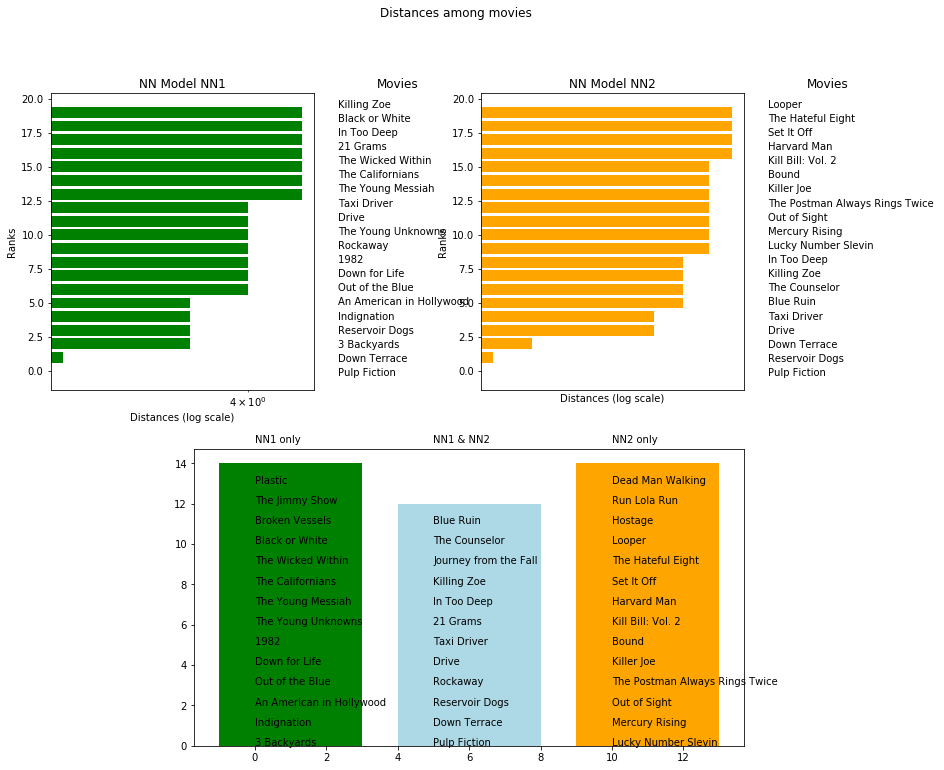

In [25]:
plot_comparison(nn1, dd1, nn2, dd2, lab1='NN1', lab2='NN2', n_movies = 20)

### Comments:

1. lists of movies: the lists of similar movies differ
2. distances: with both methods, movies are lumped in a few groups sharing same distance values

**1.Lists of movies**

While some movies are shared by the two models we can see clear differences.

Some movies are only present without data standardization (NN1): [3 Backyards](http://www.imdb.com/title/tt1314190/?ref_=fn_t...), [Indignation](http://www.imdb.com/title/tt4193394/?ref_=fn_t...), [An American in Hollywood](http://www.imdb.com/title/tt2125430/?ref_=fn_t...). 
Those movies are Drama rated R like *Pulp Fiction* but share no other similarities.

Some movies are only present with data standardization (NN2):
[Lucky Number Slevin](http://www.imdb.com/title/tt0425210/?ref_=fn_t...), [Mercury Rising](http://www.imdb.com/title/tt0120749/?ref_=fn_t...), [Out of Sight](http://www.imdb.com/title/tt0120780/?ref_=fn_t...). 
Model NN2 (data standardization) discards spurious similarities related to double zeros in the dataset and therefore nearest neighbors now share more features with the target movie: They are Crime | Drama movies rated R like *Pulp Fiction* but can also share some similarities on actors (eg Bruce Willis) or plot keyword (eg *neo noir*)

**2.Distances**

Data standardization prior to distance computation allowed us to keep using Euclidean distances and obtain a similar result as a Jaccard's distances. Distances now seem to reflect more accurately what we would call similarities among movies.

However, the two methods give many tied movies that share the exact same distances to the target. This is not a good property for a ranking system.


In [26]:
idx =[3200]
idx.extend([i for i in nn1.flatten() if i not in nn2.flatten() ][:3])
idx.extend([i for i in nn2.flatten() if i not in nn1.flatten() ][:3])
donnees[['movie_title','director_name', 'content_rating', 'genres', 'plot_keywords', 
         'actor_1_name', 'actor_2_name', 'actor_3_name']].iloc[idx]

,movie_title,director_name,content_rating,genres,plot_keywords,actor_1_name,actor_2_name,actor_3_name
3200,Pulp Fiction,Quentin Tarantino,R,Crime|Drama,black comedy|cunnilingus|neo noir|nonlinear ti...,Bruce Willis,Eric Stoltz,Phil LaMarr
4490,3 Backyards,Eric Mendelsohn,R,Drama,number in title,Embeth Davidtz,Edie Falco,Kathryn Erbe
2294,Indignation,James Schamus,R,Drama,based on novel,Logan Lerman,Sarah Gadon,Tracy Letts
4570,An American in Hollywood,Sai Varadan,R,Drama,place name in title,J.D. Williams,Hassan Johnson,Samantha Esteban
1750,Lucky Number Slevin,Paul McGuigan,R,Crime|Drama|Mystery|Thriller,coroner|death|gay son|love|mistaken identity,Bruce Willis,Morgan Freeman,Dorian Missick
760,Mercury Rising,Harold Becker,R,Action|Crime|Drama|Thriller,autistic child|boy|child in danger|fbi|nsa,Bruce Willis,Miko Hughes,Carrie Preston
1018,Out of Sight,Steven Soderbergh,R,Crime|Drama|Romance|Thriller,heist|neo noir|one last job|opposites attract|...,Don Cheadle,Albert Brooks,Keith Hudson




-------------------

# 3. Sparse data and data transformation

Our dataset is very sparse we're likely to encounter another issue: a ranking poorly discriminant with lot of tied movies. If we look at the four movies *Pulp Fiction*, *Lucky Number Slevin*, *Mercury Rising* and *Out of Sight* we can see that they share only a low number of similarity relatively to the total number of features in the dataset even though those movies are our current nearest neighbors.

Due to the low information in the dataset, we can only obtain a limited number of different values for computed distances and end up with tied movies

In [27]:
tmp = df_cat1.iloc[[3200,1750,760,1018]]
tmp.loc[:,tmp.sum(axis=0)>1]

,crime,drama,thriller,bruce willis,KW_neo noir,content_rating_R
3200,1,1,0,1,1,1
1750,1,1,1,1,0,1
760,1,1,1,1,0,1
1018,1,1,1,0,1,1


To gain more precision, ideally we would need to gather more information from an external source and add informative variables to the dataset. Otherwise, another solution is to transform the data to bring more variations. Unlike standardization, transformation implies a change of the information of the initial dataset. Such operation must be well argumented.

![SamuelLJackson](samuel-l-jackson-pulp-fiction.png)

### Variables weighting
The most straightforward way is to weight some variables relatively to others so that you give them more importance when calculating distances among objects. This way the wole dataset information will be richer and ties will be rarer when looking for nearest neighbors of a target object.

*(For more details, please see the companion notebook in this repository: [Distance_Assessment](2.Annex_Distance_assessment.ipynb))*


- **weighting based on expert knowledge:** when you know which variables should hold more or less importance in distance calculations relatively to your question you can choose manually the different weights to apply
- **giving more weight to frequent variables:** when you consider that the more frequent variables are more important
- **giving more weight to unfrequent variables:** when small 'details' are considered to be the more informative discriminants

To achieve that, we could base the weights values on the marginal sums of columns btu we could also explore the use of a **PCA** or a **Chi-square** transformation.

------------------------------

# Application on movie dataset

### 3.1 More weight to unfrequent variables: chi-square transformation
Euclidean distances computed after a Chi-square transformation are expected to yield similar results as Chi-square distances. One known property is to give relatively more importance to less frequent variables

In [28]:
from utils import chi_tab
# model with weighting based on chi-square transformatioµn
NN6 = NearestNeighbors(n_neighbors=26, algorithm='auto', metric='euclidean')
NN6.fit(df_normalization(chi_tab(df_cat1)))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                 radius=1.0)

In [29]:
dd2, nn2 = NN2.kneighbors([np.array(df_normalization(df_cat1).loc[3200])], return_distance=True)
dd6, nn6 = NN6.kneighbors([np.array(df_normalization(chi_tab(df_cat1)).loc[3200])], return_distance=True)

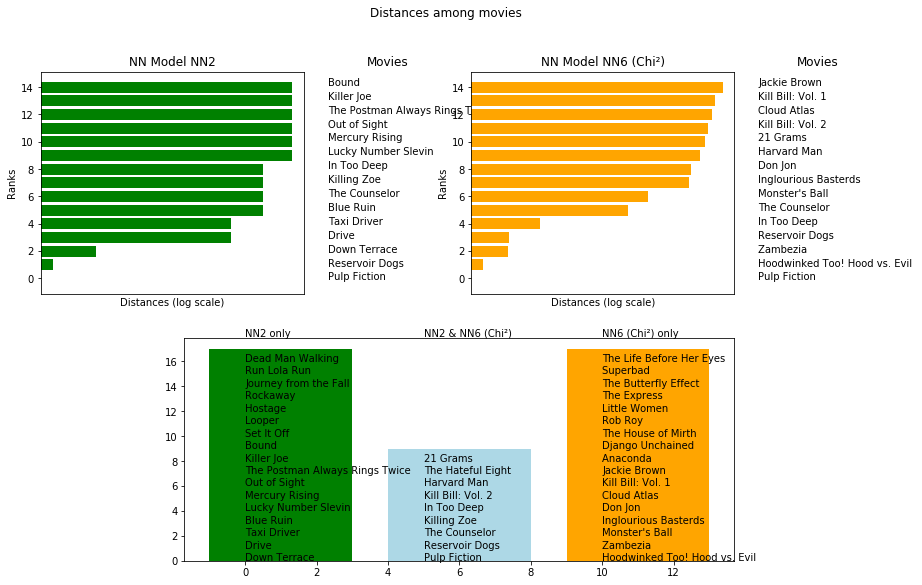

In [30]:
plot_comparison(nn1=nn2, dd1=dd2, nn2=nn6, dd2=dd6, lab1='NN2', lab2='NN6 (Chi²)', n_movies = 15)

### Comments

With the data transformation, we manage to obtain a more continuous range of distances

However,the Chi-square distances lead to somewhat weird results because they give more weight to *rare similarities*. In particular, the first two closest movies from Pulp Fiction would be [Hoodwinked Too! Hood vs. Evil](http://www.imdb.com/title/tt0844993/?ref_=fn_t...) and [Zambezia](http://www.imdb.com/title/tt1488181/?ref_=fn_t...)... two animations movies voiced by actor Phil LaMarr who also played in Pulp Fiction! Conversely we lose movies like [Down Terrace](http://www.imdb.com/title/tt1489167/?ref_=fn_t...) or [Drive](http://www.imdb.com/title/tt0780504/?ref_=fn_t...) that were obviously more simlar to Pulp Fiction

**Note:** Similar result would have been obtained with weight based on the inverse of the variables frequencies

In [31]:
idx =[3200]
idx.extend([i for i in nn2.flatten() if i not in nn6.flatten() ][:3])
idx.extend([i for i in nn6.flatten() if i not in nn2.flatten() ][:3])
donnees[['movie_title','director_name', 'content_rating', 'genres', 'plot_keywords', 
         'actor_1_name', 'actor_2_name', 'actor_3_name']].iloc[idx]

,movie_title,director_name,content_rating,genres,plot_keywords,actor_1_name,actor_2_name,actor_3_name
3200,Pulp Fiction,Quentin Tarantino,R,Crime|Drama,black comedy|cunnilingus|neo noir|nonlinear ti...,Bruce Willis,Eric Stoltz,Phil LaMarr
4618,Down Terrace,Ben Wheatley,R,Comedy|Crime|Drama,black comedy,Michael Smiley,Tony Way,David Schaal
2544,Drive,Nicolas Winding Refn,R,Crime|Drama,kissing in an elevator|mythical hero|neo noir|...,Ryan Gosling,Albert Brooks,Russ Tamblyn
4236,Taxi Driver,Martin Scorsese,R,Crime|Drama,loner|neo noir|night shift|taxi driver|vigilante,Robert De Niro,Albert Brooks,Peter Boyle
1649,Hoodwinked Too! Hood vs. Evil,Mike Disa,PG,Animation|Comedy|Family,3 dimensional|box office flop|critically bashe...,Amy Poehler,Phil LaMarr,Cheech Marin
2260,Zambezia,Wayne Thornley,G,Adventure|Animation|Comedy|Family,bird|city name in title|falcon|one word title|...,Leonard Nimoy,Phil LaMarr,Noureen DeWulf
3686,Monster's Ball,Marc Forster,R,Drama|Romance,cunnilingus|female frontal nudity|female nudit...,Heath Ledger,Peter Boyle,Marcus Lyle Brown


-------------------

### 3.2 More weight to frequent variables:  based on marginal sum of columns

Here we expect to give more importance to frequent variables. The weights are computed as the square root of the marginal sums of the variables  

In [32]:
from utils import col_weighting

# model with weighting based on sqrt(column sum)
NN3 = NearestNeighbors(n_neighbors=26, algorithm='auto', metric='euclidean')
NN3.fit(df_normalization(col_weighting(df_cat1, fun=lambda x: np.sqrt(x))))

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                 radius=1.0)

In [33]:
dd2, nn2 = NN2.kneighbors([np.array(df_normalization(df_cat1).loc[3200])], return_distance=True)
dd3, nn3 = NN3.kneighbors([np.array(df_normalization(col_weighting(df_cat1, fun=lambda x: np.sqrt(x))).loc[3200])], return_distance=True)

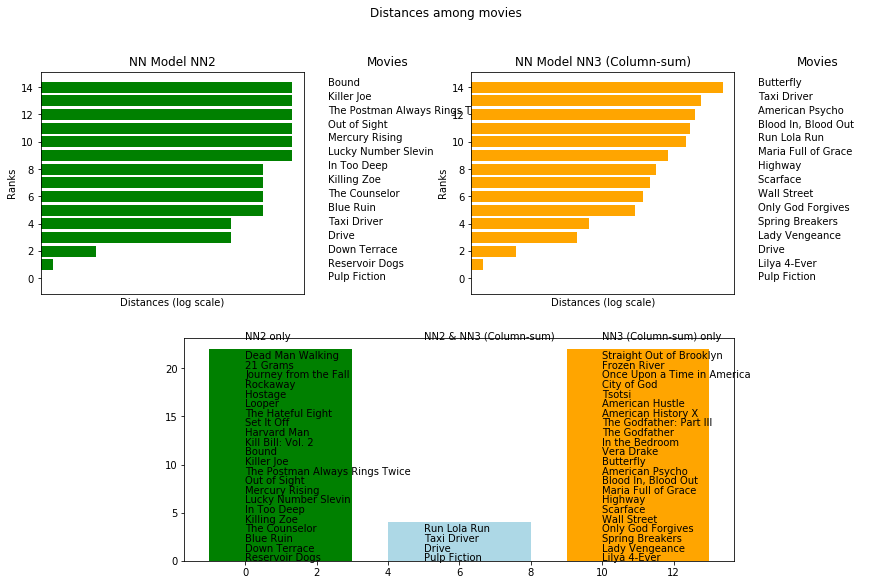

In [34]:
plot_comparison(nn1=nn2, dd1=dd2, nn2=nn3, dd2=dd3, lab1='NN2', lab2='NN3 (Column-sum)', n_movies = 15)

### Comments
Once again with this transformation, we manage to obtain a more continuous range of distances. Let's look at the movies promoted by each model:
- NN2 only: [Reservoir Dogs](http://www.imdb.com/title/tt0105236/?ref_=fn_t...), [Down Terrace](http://www.imdb.com/title/tt1489167/?ref_=fn_t...), [Blue Ruin](http://www.imdb.com/title/tt2359024/?ref_=fn_t...)
- NN3 only: [Lilya 4-Ever](http://www.imdb.com/title/tt0300140/?ref_=fn_t...), [Lady Vengeance](http://www.imdb.com/title/tt0451094/?ref_=fn_t...), [Spring Breakers](http://www.imdb.com/title/tt2101441/?ref_=fn_t...)

While the list of movies from the NN3 model isn't as weird as the list obtained when giving more importance to less frequent variables, the movies promoted by the model NN2 seem intuitively more similar to Pulp Fiction. What happened? 

The most frequent variables in the dataset are *'content_rating'* and *'genres'*. The NN3 model gives them a lot of weight and consequently movies classified exactly as *Crime|Drama* and rated *R* like *Pulp Fiction* are promoted. However, even though *Pulp Fiction* isn't classified as *Comedy* or *Thriller* it has some characteristics of these genres and thanks to some similarities on plot_keywords, realisator or actors, the  former model NN2 managed to place such movies in the top list. Thus, the weights given by NN3 appear a bit too high and the model lacks some flexibility.

In [35]:
idx =[3200]
idx.extend([i for i in nn2.flatten() if i not in nn3.flatten() ][:3])
idx.extend([i for i in nn3.flatten() if i not in nn2.flatten() ][:3])
donnees[['movie_title','director_name', 'content_rating', 'genres', 'plot_keywords', 
         'actor_1_name', 'actor_2_name', 'actor_3_name']].iloc[idx]

,movie_title,director_name,content_rating,genres,plot_keywords,actor_1_name,actor_2_name,actor_3_name
3200,Pulp Fiction,Quentin Tarantino,R,Crime|Drama,black comedy|cunnilingus|neo noir|nonlinear ti...,Bruce Willis,Eric Stoltz,Phil LaMarr
4204,Reservoir Dogs,Quentin Tarantino,R,Crime|Drama|Thriller,gang|heist|heist gone wrong|nonlinear timeline...,Quentin Tarantino,Steve Buscemi,Chris Penn
4618,Down Terrace,Ben Wheatley,R,Comedy|Crime|Drama,black comedy,Michael Smiley,Tony Way,David Schaal
4455,Blue Ruin,Jeremy Saulnier,R,Crime|Drama|Thriller,blood splatter|car|neo noir|vengeance|vomiting,Devin Ratray,Eve Plumb,Amy Hargreaves
3665,Lilya 4-Ever,Lukas Moodysson,R,Crime|Drama,abandoned by mother|poverty|sex trade|teenage ...,Oksana Akinshina,Artyom Bogucharskiy,Lyubov Agapova
3660,Lady Vengeance,Chan-wook Park,R,Crime|Drama,cake|christian|lesbian sex|oral sex|pregnant s...,Min-sik Choi,Yeong-ae Lee,Hye-jeong Kang
3550,Spring Breakers,Harmony Korine,R,Crime|Drama,kissing a dead body|repeated dialogue|sex in p...,James Franco,Heather Morris,Rachel Korine


-------------------------

### 3.2 More weight to frequent variables:   based on PCA

In [36]:
from sklearn import decomposition
pca_cat = decomposition.PCA(n_components=2000,random_state=0)
pca_cat.fit(df_normalization(df_cat1))
df_pca = pd.DataFrame(pca_cat.transform(df_normalization(df_cat1)),index= df_cat1.index)
print(df_pca.shape)
print('explained variance: ',pca_cat.explained_variance_ratio_.cumsum())

(4645, 2000)
explained variance:  [0.03990014 0.0726438  0.10040655 ... 0.80556722 0.80567954 0.80579173]


In [37]:
# model with weighting based on PCA
NN5 = NearestNeighbors(n_neighbors=26, algorithm='auto', metric='euclidean')
NN5.fit(df_pca)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=26, p=2,
                 radius=1.0)

In [38]:
dd2, nn2 = NN2.kneighbors([np.array(df_normalization(df_cat1).loc[3200])], return_distance=True)
dd5, nn5 = NN5.kneighbors([np.array(df_pca.loc[3200])], return_distance=True)

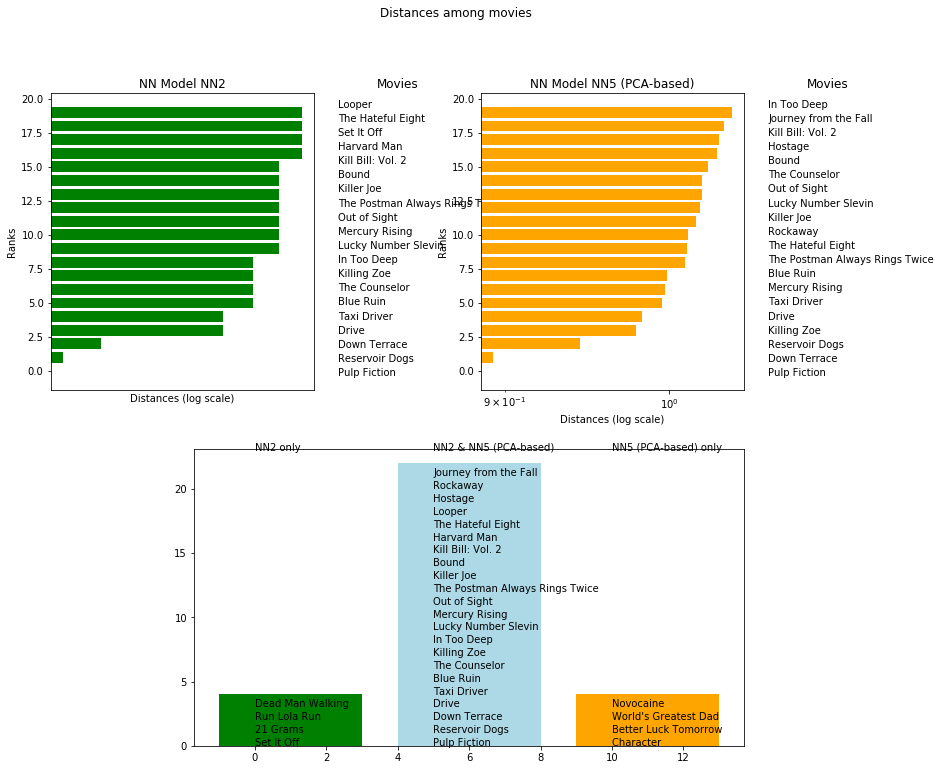

In [39]:
plot_comparison(nn1=nn2, dd1=dd2, nn2=nn5, dd2=dd5, lab1='NN2', lab2='NN5 (PCA-based)', n_movies = 20)

Unlike model NN3, the NN5 model based on a PCA returns a list of movies which is very similar to the list returned by our NN2 model. Actually the differences concern movies that aren't in the top 10. Compared to NN2, the NN5 model based on a PCA returns a continuous range of distances and allow a ranking which seems plausible:

1.[Down Terrace](http://www.imdb.com/title/tt1489167/?ref_=fn_t...), 2.[Reservoir Dogs](http://www.imdb.com/title/tt0105236/?ref_=fn_t...), 3.[Killing Zoe](http://www.imdb.com/title/tt0110265/?ref_=fn_t...), 4.[Drive](http://www.imdb.com/title/tt0780504/?ref_=fn_t...),  5.[Taxi Driver](http://www.imdb.com/title/tt0075314/?ref_=fn_t...).

In summary, PCA promotes variables holding a non redundant information that structures the dataset. The importance given to a variable by this transformation will depend on the retained proportion of the initial information (here around 80%). Compared to the transformation based on marginal sum of columns (NN3), the PCA-based weighting is more flexible and takes into account correlations among variables.
*To find out the precise weights given by this method to each variable we can look at the relative contribution of the variables to the new dimensions (cf [Distance_Assessment](2.Annex_Distance_assessment.ipynb)) )*

In [41]:
donnees[['movie_title','director_name', 'content_rating', 'genres', 'plot_keywords', 
         'actor_1_name', 'actor_2_name', 'actor_3_name']].iloc[nn5.flatten()[:6]]

,movie_title,director_name,content_rating,genres,plot_keywords,actor_1_name,actor_2_name,actor_3_name
3200,Pulp Fiction,Quentin Tarantino,R,Crime|Drama,black comedy|cunnilingus|neo noir|nonlinear ti...,Bruce Willis,Eric Stoltz,Phil LaMarr
4618,Down Terrace,Ben Wheatley,R,Comedy|Crime|Drama,black comedy,Michael Smiley,Tony Way,David Schaal
4204,Reservoir Dogs,Quentin Tarantino,R,Crime|Drama|Thriller,gang|heist|heist gone wrong|nonlinear timeline...,Quentin Tarantino,Steve Buscemi,Chris Penn
4145,Killing Zoe,Roger Avary,R,Crime|Drama|Thriller,bank|bastille day|call girl|childhood friend|d...,Eric Stoltz,Salvator Xuereb,Jean-Hugues Anglade
2544,Drive,Nicolas Winding Refn,R,Crime|Drama,kissing in an elevator|mythical hero|neo noir|...,Ryan Gosling,Albert Brooks,Russ Tamblyn
4236,Taxi Driver,Martin Scorsese,R,Crime|Drama,loner|neo noir|night shift|taxi driver|vigilante,Robert De Niro,Albert Brooks,Peter Boyle


-------------------

# Final recommendation system

1. top 5 most similar movies with our pca-based method
2. top 5 most similar movies with our pca-based method with:
    + filter low-rated movies (eg IMDB score)
    + filter sequels of the target (similar titles)

In [233]:
def sim_movie(movie_name,NN=NN5,df=df_pca):
    '''Returns the list of similar movies
    Input: title of the target movie'''
    movie_name = movie_name+'\xa0'
    nn = donnees[donnees.movie_title == movie_name].index
    selec = NN.kneighbors([np.array(df.loc[nn[0]])], return_distance=False)
    return selec.flatten()#donnees['movie_title'].iloc[selec[0]]

def filter_score(dat, thresh=0):
    '''Filter movies based on a given IMDB score threshold'''
    tmp = donnees.iloc[dat]
    updated = np.array(tmp[tmp.imdb_score>=thresh].index)
    return updated

def find_sequels(name1,name2):
    '''Find movie names similar to target name
    expected to be sequels related to the target'''
    name = [name2.replace(u'\xa0', u'')]
    if fuzz.ratio(name1,name)>50 or fuzz.token_set_ratio(name1,name)>50:
        return(True)
    return(False)

In [242]:
def sim_idx(movie_name,score_thresh=0, no_sequels=True, NN=NN5,df=df_pca):        
    '''Return indexes corresponding to similar movies for the target movie_name
    Based on a given NearestNeighbors model
    Returns an array with 25 indexes
    then removes indexes depending on options score and no_sequels'''
    target = movie_name
    similar = sim_movie(movie_name, NN, df)[1:] # suppress first item = target    
    ###### score
    similar = filter_score(similar, score_thresh)
    ###### sequels
    if no_sequels:
        liste_ind = []
        for idx in similar:
            if find_sequels(target,donnees.iloc[idx]['movie_title'])==False:
                liste_ind.extend([idx])
        similar = np.array(liste_ind)        
    return similar

def recomm_movie(movie_name,n_top=5, score_thresh=0,
                 no_sequels=True, NN=NN5,df=df_pca):
    '''Returns the name of the selected movie as a Series'''
    if movie_name+'\xa0' not in list(donnees['movie_title']):
        return 'Sorry, I don\'t know this movie'
    idx = sim_idx(movie_name,score_thresh, no_sequels, NN, df)[:n_top]
    return donnees['movie_title'].iloc[idx]

Let's see the results for four selected movies

In [245]:
targets = ['Pulp Fiction', 'Toy Story', 'Out of Africa', 'The Fast and the Furious']
tmp1 = []
tmp2 = []
for movie in targets:
    tmp1.extend([list(recomm_movie(movie,n_top=5,
             score_thresh=0, no_sequels=False))])
    tmp2.extend([list(recomm_movie(movie,n_top=5,
             score_thresh=7, no_sequels=True))])


df1 = pd.DataFrame(np.array(tmp1).T, columns=targets)
df2 = pd.DataFrame(np.array(tmp3).T, columns=targets)

print('Top 5 similar movies without filter')
display(df1)
print('\n')
print('Top 5 similar movies with filters: \n No sequel and IMDB score at least 7')
display(df2)

Top 5 similar movies without filter


,Pulp Fiction,Toy Story,Out of Africa,The Fast and the Furious
0,Down Terrace,Toy Story 3,Becoming Jane,The Skulls
1,Reservoir Dogs,Toy Story 2,The Singles Ward,Furious 7
2,Killing Zoe,A Bug's Life,Mao's Last Dancer,Fast Five
3,Drive,"Monsters, Inc.",Red Dog,xXx
4,Taxi Driver,Cars,Tootsie,Takers




Top 5 similar movies with filters: 
 No sequel and IMDB score at least 7


,Pulp Fiction,Toy Story,Out of Africa,The Fast and the Furious
0,Reservoir Dogs,A Bug's Life,Becoming Jane,Fast Five
1,Drive,"Monsters, Inc.",Mao's Last Dancer,District B13
2,Taxi Driver,Cars,Red Dog,RED
3,Blue Ruin,Brave,Tootsie,The Italian Job
4,The Hateful Eight,The Emperor's New Groove,Miss Potter,Running Scared




-------------------------

![Winston](winston.png)

Here we managed to assess similarities among movies by computing distances on a limited set of categorical variables and we used data standardization and transformations to avoid spurious similarities and make sure that Euclidean distances can actually reflect consistent similarities in movie contents. 

Of course, our 'recommendation system' would gain in precision with more information.

## To go further


- **1.enhancement of data enrichment: **
Among our variables, 'plot_keywords' could be made more informative by gathering together the keywords with close meanings. A deep NLP analysis followed by a k-means clustering for instance.


- **2.enrichment through use of external data: **
Obviously, finding some more data would be a way to add more information about the content of the movies to our dataset. Rather than using a few plot keywords, we could work with full resumes of the plot.

---------------------------